In [16]:
import pandas as pd
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt

# Set random seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Prepare data for two targets simultaneously
def prepare_data(device, path, n_samples=500, test_size=0.2, recal_size=0.2, batch_size=32, seed=5, bootstrap=False):
    set_seed(seed)
    data = pd.read_excel(path)

    if bootstrap:
        data = data.sample(n=n_samples, replace=True, random_state=seed)
    else:
        data = data.sample(n=n_samples, random_state=seed)

    X = data.iloc[:, :-2].values
    y = data.iloc[:, -2:].values  # BOTH TARGETS

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    recal_split = recal_size / (1 - test_size)
    X_train, X_recal, y_train, y_recal = train_test_split(X_temp, y_temp, test_size=recal_split, random_state=seed)

    # Tensors
    X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
    X_recal, y_recal = torch.tensor(X_recal).float(), torch.tensor(y_recal).float()
    X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()
    
    mean_X, std_X = X_train.mean(0), X_train.std(0)
    mean_y, std_y = y_train.mean(0), y_train.std(0)

    X_train = (X_train - mean_X) / std_X
    X_recal = (X_recal - mean_X) / std_X
    X_test = (X_test - mean_X) / std_X

    y_train = (y_train - mean_y) / std_y
    y_recal = (y_recal - mean_y) / std_y
    y_test = (y_test - mean_y) / std_y

    # Device
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_recal, y_recal = X_recal.to(device), y_recal.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    recal_loader = DataLoader(TensorDataset(X_recal, y_recal), batch_size=batch_size, shuffle=False)

    return X_train, y_train, train_loader, X_recal, y_recal, recal_loader, X_test, y_test, mean_X, std_X, mean_y, std_y

# Training
set_seed(5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "synthetic_data.xlsx"
X_train, y_train, train_loader, X_recal, y_recal, recal_loader, X_test, y_test, mean_X, std_X, mean_y, std_y = prepare_data(device, file_path, n_samples = 400)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import norm
import matplotlib.pyplot as plt

# ==== 1. MC Dropout Multi-output Model ====

class MultiOutputMCDropout(nn.Module):
    def __init__(self, input_size, n_hidden=32, dropout_p=0.4):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc1 = nn.Linear(input_size, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc_mean = nn.Linear(n_hidden, 2)
        self.fc_cov = nn.Linear(n_hidden, 3)

    def forward(self, x):
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(self.dropout(x)))
        mean = self.fc_mean(self.dropout(x))
        cov_params = self.fc_cov(self.dropout(x))

        log_var = cov_params[:, :2]
        rho = 0.99 * torch.tanh(cov_params[:, 2])  # bounded correlation
        std = torch.exp(0.5 * log_var)
        cov12 = rho * std[:, 0] * std[:, 1]

        cov_matrix = torch.zeros(x.size(0), 2, 2, device=x.device)
        cov_matrix[:, 0, 0] = std[:, 0] ** 2
        cov_matrix[:, 1, 1] = std[:, 1] ** 2
        cov_matrix[:, 0, 1] = cov12
        cov_matrix[:, 1, 0] = cov12
        return mean, cov_matrix

# ==== 2. Loss Function ====

def multi_output_nll(mean, cov_matrix, y_true):
    eps = 1e-3
    eye = torch.eye(2, device=cov_matrix.device).unsqueeze(0)
    cov_pd = cov_matrix + eps * eye
    dist = torch.distributions.MultivariateNormal(loc=mean, covariance_matrix=cov_pd)
    return -dist.log_prob(y_true).mean()

# ==== 3. Training ====

def train_mc_dropout_model(model, optimizer, train_loader, device, epochs=1000):
    loss_history = []
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            mean, cov = model(X_batch)
            loss = multi_output_nll(mean, cov, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss)
        if epoch % 500 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.4f}")

    # Plot training loss
    plt.plot(range(1, epochs + 1), loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.show()
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = MultiOutputMCDropout(input_size=X_train.shape[1], n_hidden=32, dropout_p=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_mc_dropout_model(model, optimizer, train_loader, device)

Epoch 1/1000, Loss: 21.9314


KeyboardInterrupt: 

In [ ]:

# ==== 4. Inference with MC Dropout ====

def mc_predict_with_uncertainty(model, X, n_samples, device):
    model.train()  # Keep dropout active
    all_means, all_covs = [], []
    X = X.to(device)
    with torch.no_grad():
        for _ in range(n_samples):
            mean, cov = model(X)
            all_means.append(mean.cpu().numpy())
            all_covs.append(cov.cpu().numpy())
    return np.stack(all_means), np.stack(all_covs)

def calculate_uncertainties(mc_means, mc_covs):
    epistemic = np.var(mc_means, axis=0)
    aleatoric = np.mean(np.diagonal(mc_covs, axis1=2, axis2=3), axis=0)
    return epistemic, aleatoric, epistemic + aleatoric

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

def calc_interval_picp(y_true, y_pred, total_unc, confidence=0.80):
    z = norm.ppf((1 + confidence) / 2)
    lower = y_pred - z * np.sqrt(total_unc)
    upper = y_pred + z * np.sqrt(total_unc)
    picp = np.mean((y_true >= lower) & (y_true <= upper)) * 100
    return lower, upper, picp

n_mc = 300

train_means, train_covs = mc_predict_with_uncertainty(model, X_train, n_mc, device)
test_means, test_covs = mc_predict_with_uncertainty(model, X_test, n_mc, device)
recal_means, recal_covs = mc_predict_with_uncertainty(model, X_recal, n_mc, device)

train_pred = train_means.mean(axis=0)
test_pred = test_means.mean(axis=0)
recal_pred = recal_means.mean(axis=0)

y_train_np, y_test_np, y_recal_np = y_train.cpu().numpy(), y_test.cpu().numpy(), y_recal.cpu().numpy()

train_epi, train_ale, train_tot = calculate_uncertainties(train_means, train_covs)
test_epi, test_ale, test_tot = calculate_uncertainties(test_means, test_covs)
recal_epi, recal_ale, recal_tot = calculate_uncertainties(recal_means, recal_covs)

# Print metrics
for name, pred, y_true, tot_unc, epi, ale in [
    ('Train', train_pred, y_train_np, train_tot, train_epi, train_ale),
    ('Test',  test_pred,  y_test_np,  test_tot,  test_epi,  test_ale)
]:
    print(f"\n{name} Set Metrics:")
    for idx, target_label in enumerate(['Measured voltage', 'Predicted voltage']):
        mae, mse, rmse, r2 = evaluate_model(y_true[:, idx], pred[:, idx])
        lb, ub, picp = calc_interval_picp(y_true[:, idx], pred[:, idx], tot_unc[:, idx], confidence=0.80)
        print(f"  {target_label}:")
        print(f"    MAE:            {mae:.4f}")
        print(f"    RMSE:           {rmse:.4f}")
        print(f"    R²:             {r2:.4f}")
        print(f"    PICP (80%):     {picp:.2f}%")
        print(f"    Epistemic (μ):  {epi[:, idx].mean():.4f}")
        print(f"    Aleatoric (μ):  {ale[:, idx].mean():.4f}")


Train Set Metrics:
  Measured voltage:
    MAE:            0.0370
    RMSE:           0.0565
    R²:             0.9968
    PICP (80%):     99.93%
    Epistemic (μ):  0.0245
    Aleatoric (μ):  0.0280
  Predicted voltage:
    MAE:            0.4005
    RMSE:           0.5100
    R²:             0.7397
    PICP (80%):     87.87%
    Epistemic (μ):  0.0288
    Aleatoric (μ):  0.2914

Test Set Metrics:
  Measured voltage:
    MAE:            0.0360
    RMSE:           0.0603
    R²:             0.9963
    PICP (80%):     100.00%
    Epistemic (μ):  0.0243
    Aleatoric (μ):  0.0274
  Predicted voltage:
    MAE:            0.4252
    RMSE:           0.5566
    R²:             0.7107
    PICP (80%):     85.40%
    Epistemic (μ):  0.0290
    Aleatoric (μ):  0.2926


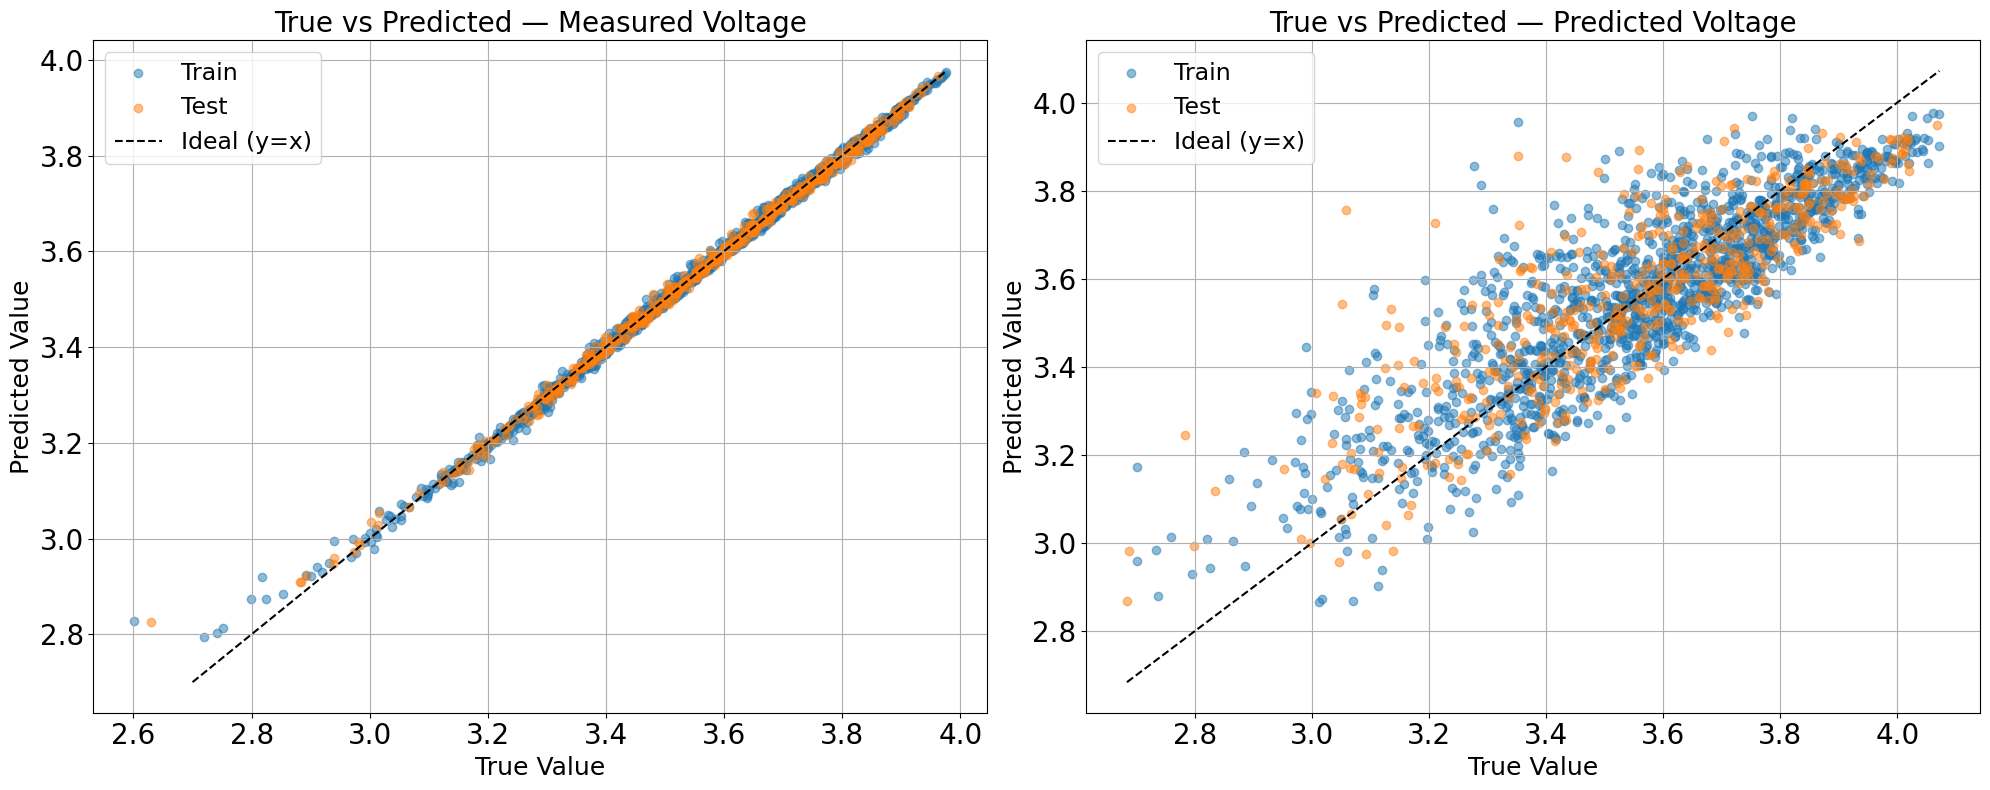

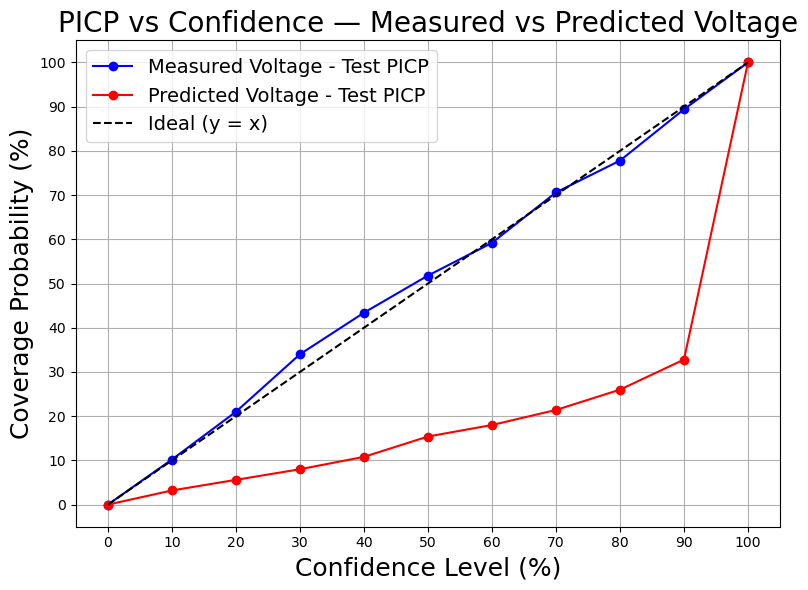

In [ ]:
# -------------------------------
# 8. De-normalization and Scatter Plot
# -------------------------------

def de_normalize(data, mean, std):
    mean_np = mean.cpu().numpy() if isinstance(mean, torch.Tensor) else mean
    std_np  = std.cpu().numpy()  if isinstance(std, torch.Tensor) else std
    return data * std_np + mean_np

# Denormalize predictions + ground truth
train_preds_denorm = de_normalize(train_pred, mean_y, std_y)
test_preds_denorm  = de_normalize(test_pred,  mean_y, std_y)
y_train_denorm     = de_normalize(y_train.cpu().numpy(), mean_y, std_y)
y_test_denorm      = de_normalize(y_test.cpu().numpy(),  mean_y, std_y)
num_samples = len(y_train) + len(y_test) + len(y_recal)

# Plot true vs predicted
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
target_names = ['Measured Voltage', 'Predicted Voltage']

# De-normalize total predictive variance
std_y_np = std_y.cpu().numpy()
train_tot = train_tot * (std_y_np ** 2)
test_tot  = test_tot  * (std_y_np ** 2)

for i, target_name in enumerate(target_names):
    ax = axes[i]
    ax.scatter(y_train_denorm[:, i], train_preds_denorm[:, i], alpha=0.5, label='Train')
    ax.scatter(y_test_denorm[:, i],  test_preds_denorm[:, i],  alpha=0.5, label='Test')

    # Diagonal line
    start = 2.7 if i == 0 else min(y_train_denorm[:, i].min(), y_test_denorm[:, i].min())
    end   = max(y_train_denorm[:, i].max(), train_preds_denorm[:, i].max(),
                y_test_denorm[:, i].max(), test_preds_denorm[:, i].max())
    ax.plot([start, end], [start, end], '--', color='black', label='Ideal (y=x)')

    # **Double-sized text**
    ax.set_xlabel('True Value',      fontsize=18)   # was ~12 → now ~24
    ax.set_ylabel('Predicted Value', fontsize=18)
    ax.set_title(
        f'True vs Predicted — {target_name}', #({num_samples} samples)',
        fontsize=20  # was ~16 → now ~32
    )
    ax.legend(fontsize=12+5)              # was ~12 → now ~24
    ax.tick_params(axis='both', labelsize=10*2)  # was ~10 → now ~20
    ax.grid(True)

plt.tight_layout()
plt.show()
# -------------------------------
# 9. PICP Plotting over Confidence Levels
# -------------------------------

confidence_levels = np.linspace(0, 1, 11)
train_picps = {1: [], 2: []}
test_picps  = {1: [], 2: []}

# Compute PICP for each confidence level
for cl in confidence_levels:
    for idx in range(2):
        _, _, picp_train = calc_interval_picp(y_train.cpu().numpy()[:, idx], train_pred[:, idx], train_tot[:, idx], cl)
        _, _, picp_test  = calc_interval_picp(y_test.cpu().numpy()[:, idx],  test_pred[:, idx],  test_tot[:, idx],  cl)

        train_picps[idx + 1].append(picp_train)
        test_picps[idx + 1].append(picp_test)

# Plot PICP vs Confidence for both Predicted and Measured Voltage
fig, ax = plt.subplots(figsize=(8, 6))

# Plot PICP for Test set for both Predicted and Measured Voltage (target_names[0] = Measured Voltage, target_names[1] = Predicted Voltage)
ax.plot(confidence_levels * 100, test_picps[1], marker='o', label=f'Measured Voltage - Test PICP', linestyle='-', color='blue')
ax.plot(confidence_levels * 100, test_picps[2], marker='o', label=f'Predicted Voltage - Test PICP', linestyle='-', color='red')

# Plot Ideal line (y = x) for reference
ax.plot([0, 100], [0, 100], linestyle='--', label='Ideal (y = x)', color='black')

# Set plot labels and title
ax.set_xlabel('Confidence Level (%)', fontsize=18)
ax.set_ylabel('Coverage Probability (%)', fontsize=18)
ax.set_title('PICP vs Confidence — Measured vs Predicted Voltage', fontsize=20)

# Set ticks and grid
ax.set_xticks(np.linspace(0, 100, 11))
ax.set_yticks(np.linspace(0, 100, 11))
ax.grid(True)

# Add legend
ax.legend(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

